In [9]:
# autoreload
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('../')
from data.utils import setup_dataloaders, collect_pairs_choices
from eval.utils import load_model
import torch
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use('science')

device='cuda:0'

# Load the models
save_dict = {
    'btl' : '../saves/reward-models-synthetic/synthetic-btl_0',
    'dpl' : '../saves/reward-models-synthetic/synthetic-dpl_0',
    'nppl' : '../saves/reward-models-synthetic/synthetic-nppl_0',
}

models = {}
for k, v in save_dict.items():
    model, cfg = load_model(v, load_it='best')
    models[k] = model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
../saves/reward-models-synthetic/synthetic-btl_0
../saves/reward-models-synthetic/synthetic-dpl_0
../saves/reward-models-synthetic/synthetic-nppl_0


/mnt/pdata/knk25/cPL/eval/../eval/utils.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{save_dir}/model_{load_it}.pt', map_location=device)


In [10]:
from tqdm import tqdm

test_data_loader = setup_dataloaders(cfg.data, splits=['test'])['test']

num_context_ls = [0, 1, 3, 5, 10]

eval_dict = {}

for model_name, model in models.items():
    eval_dict[model_name] = {}
    for metric in ['accuracy', 'unseen_accuracy', 'label']:
        eval_dict[model_name][metric] = {}
        for num_context in num_context_ls:
            eval_dict[model_name][metric][num_context] = []

for model_name, model in models.items():
    print('Evaluting model:', model_name)
    for i, batch in enumerate(tqdm(test_data_loader)):
        for num_context in num_context_ls:
            
            pairs_C, choices_C, pairs_T, choices_T = collect_pairs_choices(
                batch, 
                num_context=num_context,
                min_num_context=cfg.data.min_num_context,
                max_num_context=cfg.data.max_num_context,
                num_targets=cfg.data.num_targets,
                context_datatype=cfg.data.context_datatype
            )  

            pairs_T = pairs_T.to(device)
            choices_T = choices_T.to(device)
            pairs_C = pairs_C.to(device)
            choices_C = choices_C.to(device) 

            with torch.no_grad():
                outputs = model(pairs_T, choices_T, pairs_C, choices_C)
            
            predictions = outputs['logp_choices'].argmax(dim=-1).unsqueeze(-1)
            choices = choices_T.unsqueeze(0).expand(predictions.shape[0], -1, -1, -1)
            acc = (predictions == choices).float().mean(axis=0)

            bs = cfg.data.batch_size
            num_targets = cfg.data.num_targets

            unseen_predictions = torch.zeros(
                (predictions.shape[0], bs, num_targets - num_context, 1)
            )
            unseen_choices = torch.zeros(
                (predictions.shape[0], bs, num_targets - num_context, 1)
            )

            for i in range(bs):
                idx = torch.tensor(list(range(num_context, num_targets)))
                unseen_predictions[:, i, :, :] = predictions[:, i, idx, :]
                unseen_choices[:, i, :, :] = choices[:, i, idx, :]

            unseen_acc = (unseen_predictions == unseen_choices).float().mean(axis=0)
        
            eval_dict[model_name]['accuracy'][num_context].append(acc)
            eval_dict[model_name]['unseen_accuracy'][num_context].append(unseen_acc)
            eval_dict[model_name]['label'][num_context].append(batch['labels_T'])

Evaluting model: btl


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:02<00:00, 13.87it/s]


Evaluting model: dpl


100%|██████████| 30/30 [00:02<00:00, 13.26it/s]


Evaluting model: nppl


100%|██████████| 30/30 [00:04<00:00,  7.48it/s]


In [11]:
import pandas as pd
num_context = 0

def get_res_df(eval_dict, acc_type="accuracy"):
    acc_dict = eval_dict[acc_type]
    labels_dict = eval_dict['label']
    res_df = pd.DataFrame()
    for num_context in num_context_ls:
        mean_acc = torch.stack(acc_dict[num_context]).squeeze(-1).mean(dim=-1).cpu().numpy()
        labels = [z for zs in labels_dict[num_context] for z in zs]
        try:
            res = pd.DataFrame({
                'acc' : mean_acc.flatten() * 100,
                'labels' : labels,
                'num_context' : num_context
            })
        except(ValueError):
            res = pd.DataFrame()
            print(acc_type, num_context)
        res_df = pd.concat([res_df, res])

    return res_df

res_df = pd.DataFrame()

for model_name in models.keys():
    res_df_model = get_res_df(eval_dict[model_name], acc_type="unseen_accuracy" if 'nppl' in model_name else "accuracy")
    res_df_model['model'] = model_name
    res_df = pd.concat([res_df, res_df_model])

summary_df = res_df.groupby(['model', 'num_context'])['acc'].agg(['mean', 'sem']) 
summary_df['acc'] = summary_df.apply(lambda x: f'{x['mean']:.1f} ± {x['sem']:.1f}', axis=1)
summary_df.reset_index().pivot(index='num_context', columns=['model'], values='acc')

model,btl,dpl,nppl
num_context,,,
0,76.4 ± 0.2,76.3 ± 0.3,76.4 ± 0.2
1,76.4 ± 0.2,76.3 ± 0.3,86.6 ± 0.3
3,76.4 ± 0.2,76.3 ± 0.3,94.7 ± 0.2
5,76.4 ± 0.2,76.3 ± 0.3,97.4 ± 0.1
10,76.4 ± 0.2,76.3 ± 0.3,98.9 ± 0.1


In [12]:
from data.gen_synthetic_data import get_choices, get_reward

n_context = 10
n = 50

options_a = torch.linspace(0, 1, n)
options_b = torch.linspace(0, 1, n)

options_a, options_b = torch.meshgrid(options_a, options_b)
options_a = options_a.flatten().view(1, -1, 1)
options_b = options_b.flatten().view(1,-1, 1)

pairs_T = torch.cat([options_a, options_b], dim=-1).unsqueeze(-1).to(device)

choices_0_T = torch.tensor(get_choices(get_reward(options_a, z=0), get_reward(options_b, z=0))).to(device)
choices_1_T = torch.tensor(get_choices(get_reward(options_a, z=1), get_reward(options_b, z=1))).to(device)

context_idx = np.random.choice(n**2, n_context)
pairs_C = pairs_T[:, context_idx]
choices_0_C = choices_0_T[:, context_idx]
choices_1_C = choices_1_T[:, context_idx]

outputs = dict(zip(models.keys(), [None]*len(models)))

with torch.no_grad():
    for model_name, model in models.items():
        outputs[model_name] = {}
        outputs[model_name]['0'] = model(pairs_T, choices_0_T, pairs_C, choices_0_C)
        outputs[model_name]['1'] = model(pairs_T, choices_1_T, pairs_C, choices_1_C)

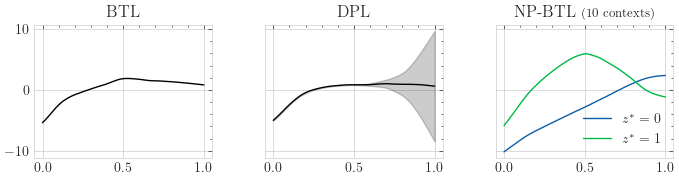

In [13]:
options = options_b.flatten().cpu().numpy()[:50]

fig, axs = plt.subplots(1, 3, figsize=(7, 2), sharex=True, sharey=True)

# BTL
rewards =  outputs['btl']['0']['rewards'][:, :, :, 1].flatten().cpu().numpy()[:50]
axs[0].plot(options, rewards, label='z=0', color='black')
axs[0].set_title('BTL')

# DPL
rewards =  outputs['dpl']['0']['rewards'][:, :, :, 1].view(-1, 2).cpu().numpy()
mean, std = rewards[:50, 0], rewards[:50, 1]
axs[1].plot(options, mean, color='black')
axs[1].fill_between(options, mean-std, mean+std, alpha=0.2, color='black')
axs[1].set_title('DPL')

# NPPL
rewards0 =  outputs['nppl']['0']['rewards'][:, :, :, 1].flatten().cpu().numpy()[:50]
rewards1 =  outputs['nppl']['1']['rewards'][:, :, :, 1].flatten().cpu().numpy()[:50]
axs[2].plot(options, rewards0, label='$z^*=0$')
axs[2].plot(options, rewards1, label='$z^*=1$')
axs[2].set_title(r'NP-BTL \small{(10 contexts)}')
axs[2].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()